# Deep Neural Networks for Nonlinear Feature Extraction

## By Mustafa Yildirim



In [ ]:
# download MNIST data from Google drive

!gdown --folder https://drive.google.com/drive/folders/1r20aRjc2iu9O3kN3Xj9jNYY2uMgcERY1 2> /dev/null

# install python_mnist

!pip install python_mnist

Processing file 1Jf2XqGR7y1fzOZNKLJiom7GmZZUzXhfs t10k-images-idx3-ubyte
Processing file 1qiYu9dW3ZNrlvTFO5fI4qf8Wtr8K-pCu t10k-labels-idx1-ubyte
Processing file 1SnWvBcUETRJ53rEJozFUUo-hOQFPKxjp train-images-idx3-ubyte
Processing file 1kKEIi_pwVHmabByAnwZQsaMgro9XiBFE train-labels-idx1-ubyte


In [ ]:
from mnist import MNIST
import numpy as np
import jax.numpy as jnp
import jax.nn as jnn
from jax import grad, random, device_put
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [ ]:
#load MINST images
mnist_loader = MNIST('MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
X_train = np.array(train_data, dtype='float')/255.0 # norm to [0,1]
y_train = np.array(train_label, dtype='short')
X_test = np.array(test_data, dtype='float')/255.0 # norm to [0,1]
y_test = np.array(test_label, dtype='short')

# convert MNIST training labels into 10-D one-hot vectors
Y_train = np.zeros((y_train.size, y_train.max()+1))
Y_train[np.arange(y_train.size),y_train] = 1

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, Y_train.shape)

(60000, 784) (60000,) (10000, 784) (10000,) (60000, 10)


In [ ]:
# implement fully-connected neural networks using JAX and jax.grad()
class myMLP3():
  def __init__(self, optimizer='sgd', debug=0, struct=[], activation='relu',\
               loss='ce', lr=1.0, max_epochs=10, batch_size=10, random_state=1,\
               init_range=1.0, annealing=1.0):
    self.optimizer = optimizer     # which optimizer is used to learn
    self.lr = lr                   # initial learning rate in SGD
    self.annealing = annealing     # annealing rate in SGD
    self.max_epochs = max_epochs   # max epochs in optimization
    self.batch_size = batch_size   # mini-batch size in SGD
    self.debug = debug             # whether print debugging info
    self.activation=activation     # activation function
    self.loss = loss               # the loss used for training objective
    self.random_state=random_state # random state
    self.init_range=init_range     # range for initializing weights

    self.struct = struct           # network structure: e.g. [100], [500, 200],
                                   #                         [100,100,100]

  # initialize internal struct/variables for input/output
  # X[N,d]: input features; Y[N,K]: 1-of-K one-hot vectors for output targets
  def initialization(self, X, Y):
    key = random.PRNGKey(self.random_state)

    input = X.shape[1]                # input dimension
    self.layers = len(self.struct)    # number of hidden layers
    self.W_b = [0]*(self.layers+1)    # list for all weight matrices

    # create weight matrices for all hidden layers
    for l in range(self.layers):
      output = self.struct[l]
      self.W_b[l] = device_put(4.90*(random.uniform(key,(input+1, output))-0.5)*self.init_range/jnp.sqrt(output+input))
      input = output

    # create weight matrix for output layer
    output = Y.shape[1]
    self.W_b[self.layers] = device_put(4.90*(random.uniform(key,(input+1, output))-0.5)*self.init_range/jnp.sqrt(output+input))

    return

  # forward pass to compute outputs for a mini-batch X
  # (refer to the box on page 166)
  # input  =>  X[B,d]: a batch of input vectors
  # return =>  y[B,K]
  def forward(self, W_b, X):

    # appending 1's to accomodate bias (see page 107)
    Z = jnp.hstack((X,jnp.ones((X.shape[0],1),dtype=X.dtype)))

    # forward pass from all hidden layers
    for l in range(self.layers):
      Z = jnn.relu(Z @ W_b[l])
      Z = jnp.hstack((Z,jnp.ones((Z.shape[0],1),dtype=Z.dtype)))

    # forward pass for output layer
    l = self.layers
    y = jnn.softmax(Z @ W_b[l], axis=1)

    return y

  # compute the CE loss for a mini-batch
  # W_b[ ]: list for all weight matrices
  # X[B,d]: input features;
  # Y[B,K]: 1-of-K one-hot vectors for output targets
  def loss_ce_batch(self, W_b, X, Y):
    R = self.forward(W_b, X)

    return -jnp.mean(jnp.log(R[Y==1]))

  # use minibatch SGD to optimize (refer to Algorithm 8.8 on page 189)
  # X[N,d]: input features; Y[N,K]: 1-of-K one-hot vectors for output targets
  def sgd(self, X, Y):
    n = X.shape[0]      # number of samples

    lr = self.lr
    errorsA = np.zeros(self.max_epochs)
    #errorsB = np.zeros(self.max_epochs)
    errorsC = np.zeros(self.max_epochs)

    for epoch in range(self.max_epochs):
      indices = np.random.permutation(n)  #randomly shuffle data indices
      for batch_start in range(0, n, self.batch_size):
        X_batch = X[indices[batch_start:batch_start + self.batch_size]]
        Y_batch = Y[indices[batch_start:batch_start + self.batch_size]]

        W_b_grad = grad(self.loss_ce_batch)(self.W_b, X_batch, Y_batch)

        for l in range(self.layers+1):
          self.W_b[l] -= lr * W_b_grad[l]

      # plot all learning curves (A, B, C)
      errorsC[epoch] = self.loss_ce_batch(self.W_b, X, Y)

      Z = self.forward(self.W_b, X)
      train_label = np.argmax(Y, axis=1)
      train_res = np.argmax(Z, axis=1)
      errorsA[epoch] = np.count_nonzero(np.equal(train_res,train_label))/train_label.size

      if(self.debug):
        print(f'epoch = {epoch} (lr={lr:.2}): C = {errorsC[epoch]:.5f}  A = {100*errorsA[epoch]:.2f}%')

      lr *= self.annealing

    return errorsA, errorsC

   # X[N,d]: input features; Y[N,K]: 1-of-K one-hot vectors for output targets
  def fit(self, X, Y):
    # initialize all weight matrices
    self.initialization(X, Y)

    X2 = device_put(X)
    Y2 = device_put(Y)

    errorsA, errorsC = self.sgd(X2, Y2)

    return errorsA, errorsC

  # X[N,d]: input features;
  # return: labels
  def predict(self, X):
    X2 = device_put(X)
    Y = self.forward(self.W_b, X2)
    return jnp.argmax(Y, axis=1)


1st Configuration

epoch = 0 (lr=0.1): C = 0.16887  A = 95.30%
epoch = 1 (lr=0.09): C = 0.10852  A = 97.06%
epoch = 2 (lr=0.081): C = 0.08698  A = 97.57%
epoch = 3 (lr=0.073): C = 0.06498  A = 98.13%
epoch = 4 (lr=0.066): C = 0.06067  A = 98.20%
epoch = 5 (lr=0.059): C = 0.02944  A = 99.15%
epoch = 6 (lr=0.053): C = 0.02340  A = 99.32%
epoch = 7 (lr=0.048): C = 0.02133  A = 99.33%
epoch = 8 (lr=0.043): C = 0.02031  A = 99.37%
epoch = 9 (lr=0.039): C = 0.01304  A = 99.62%
epoch = 10 (lr=0.035): C = 0.00658  A = 99.80%
epoch = 11 (lr=0.031): C = 0.00555  A = 99.83%
test accuracy = 98.05%


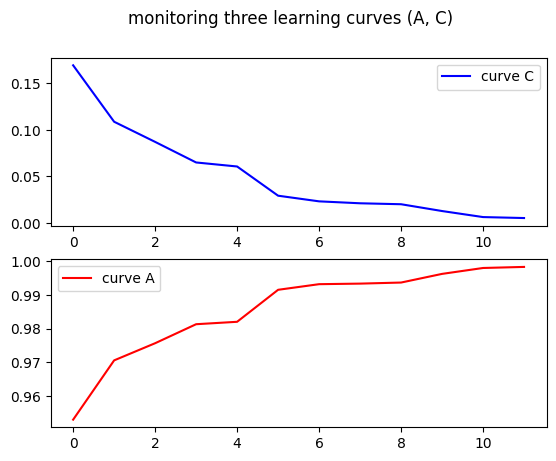

In [ ]:
mlp1 = myMLP3(struct=[128, 128, 128, 32, 128, 128, 128], debug=1, max_epochs=12, annealing=0.9, batch_size=10,lr=0.1)

A, C = mlp1.fit(X_train, Y_train)

result = mlp1.predict(X_test)

test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, C)')
ax[0].plot(C, 'b')
_=ax[0].legend(['curve C'])

ax[1].plot(A, 'r')
_=ax[1].legend(['curve A'])

2nd Configuration

epoch = 0 (lr=0.1): C = 0.13355  A = 96.17%
epoch = 1 (lr=0.09): C = 0.08525  A = 97.42%
epoch = 2 (lr=0.081): C = 0.05020  A = 98.44%
epoch = 3 (lr=0.073): C = 0.03480  A = 98.94%
epoch = 4 (lr=0.066): C = 0.01777  A = 99.44%
epoch = 5 (lr=0.059): C = 0.01609  A = 99.54%
epoch = 6 (lr=0.053): C = 0.01117  A = 99.66%
epoch = 7 (lr=0.048): C = 0.00666  A = 99.80%
epoch = 8 (lr=0.043): C = 0.00420  A = 99.89%
epoch = 9 (lr=0.039): C = 0.00438  A = 99.88%
epoch = 10 (lr=0.035): C = 0.00145  A = 99.96%
epoch = 11 (lr=0.031): C = 0.00065  A = 99.98%
test accuracy = 98.55%


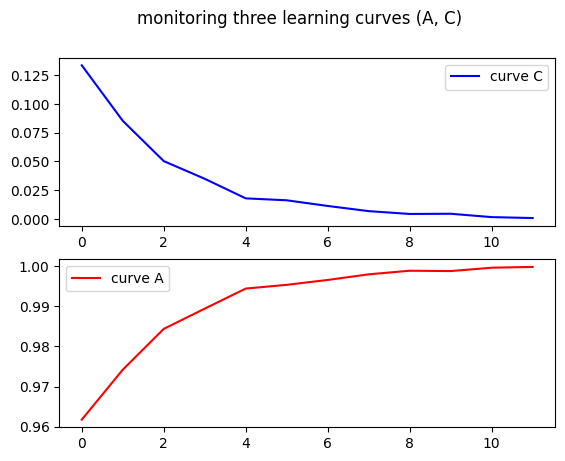

In [ ]:
mlp2 = myMLP3(struct=[512, 256, 128, 32, 128], debug=1, max_epochs=12, annealing=0.9, batch_size=10,lr=0.1)

A, C = mlp2.fit(X_train, Y_train)

result = mlp2.predict(X_test)

test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, C)')
ax[0].plot(C, 'b')
_=ax[0].legend(['curve C'])

ax[1].plot(A, 'r')
_=ax[1].legend(['curve A'])

3rd Configuration

epoch = 0 (lr=0.1): C = 0.12227  A = 96.37%
epoch = 1 (lr=0.09): C = 0.07058  A = 97.87%
epoch = 2 (lr=0.081): C = 0.05147  A = 98.44%
epoch = 3 (lr=0.073): C = 0.04979  A = 98.45%
epoch = 4 (lr=0.066): C = 0.06124  A = 98.05%
epoch = 5 (lr=0.059): C = 0.02727  A = 99.09%
epoch = 6 (lr=0.053): C = 0.02027  A = 99.32%
epoch = 7 (lr=0.048): C = 0.01423  A = 99.56%
epoch = 8 (lr=0.043): C = 0.00789  A = 99.77%
epoch = 9 (lr=0.039): C = 0.00855  A = 99.72%
epoch = 10 (lr=0.035): C = 0.00539  A = 99.84%
epoch = 11 (lr=0.031): C = 0.00271  A = 99.92%
test accuracy = 98.22%


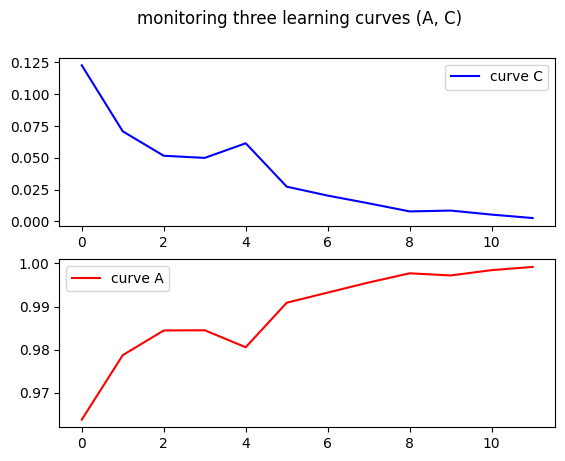

In [ ]:
mlp3 = myMLP3(struct = [128, 64, 128, 128], debug=1, max_epochs=12, annealing=0.9, batch_size=10,lr=0.1)

A, C = mlp3.fit(X_train, Y_train)

result = mlp3.predict(X_test)

test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, C)')
ax[0].plot(C, 'b')
_=ax[0].legend(['curve C'])

ax[1].plot(A, 'r')
_=ax[1].legend(['curve A'])

4th Configuration

epoch = 0 (lr=0.1): C = 0.14555  A = 95.69%
epoch = 1 (lr=0.09): C = 0.07103  A = 97.88%
epoch = 2 (lr=0.081): C = 0.04871  A = 98.57%
epoch = 3 (lr=0.073): C = 0.03868  A = 98.82%
epoch = 4 (lr=0.066): C = 0.02152  A = 99.33%
epoch = 5 (lr=0.059): C = 0.01654  A = 99.48%
epoch = 6 (lr=0.053): C = 0.01065  A = 99.67%
epoch = 7 (lr=0.048): C = 0.00913  A = 99.72%
epoch = 8 (lr=0.043): C = 0.00281  A = 99.93%
epoch = 9 (lr=0.039): C = 0.00157  A = 99.96%
epoch = 10 (lr=0.035): C = 0.00739  A = 99.80%
epoch = 11 (lr=0.031): C = 0.00089  A = 99.98%
test accuracy = 98.50%


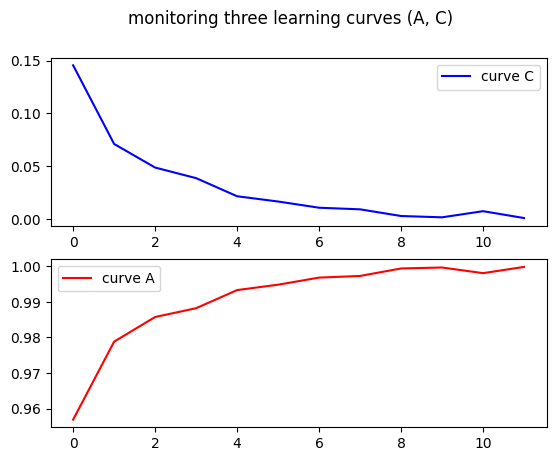

In [ ]:
mlp4 = myMLP3(struct=[512, 256, 32, 256, 512], debug=1, max_epochs=12, annealing=0.9, batch_size=10,lr=0.1)

A, C = mlp4.fit(X_train, Y_train)

result = mlp4.predict(X_test)

test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, C)')
ax[0].plot(C, 'b')
_=ax[0].legend(['curve C'])

ax[1].plot(A, 'r')
_=ax[1].legend(['curve A'])

5th Configuration

epoch = 0 (lr=0.1): C = 0.19680  A = 94.41%
epoch = 1 (lr=0.09): C = 0.13103  A = 96.11%
epoch = 2 (lr=0.081): C = 0.11590  A = 96.59%
epoch = 3 (lr=0.073): C = 0.11044  A = 96.71%
epoch = 4 (lr=0.066): C = 0.08371  A = 97.52%
epoch = 5 (lr=0.059): C = 0.07949  A = 97.59%
epoch = 6 (lr=0.053): C = 0.08635  A = 97.23%
epoch = 7 (lr=0.048): C = 0.06603  A = 98.03%
epoch = 8 (lr=0.043): C = 0.05438  A = 98.32%
epoch = 9 (lr=0.039): C = 0.04518  A = 98.61%
epoch = 10 (lr=0.035): C = 0.04726  A = 98.55%
epoch = 11 (lr=0.031): C = 0.04371  A = 98.69%
test accuracy = 96.90%


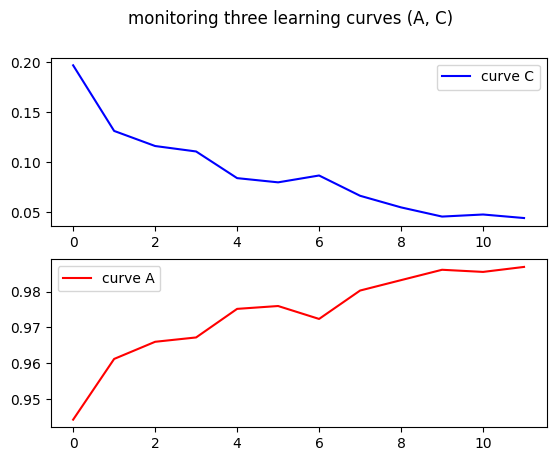

In [ ]:
mlp5 = myMLP3(struct=[32, 16, 32], debug=1, max_epochs=12, annealing=0.9, batch_size=10,lr=0.1)

A, C = mlp5.fit(X_train, Y_train)

result = mlp5.predict(X_test)

test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, C)')
ax[0].plot(C, 'b')
_=ax[0].legend(['curve C'])

ax[1].plot(A, 'r')
_=ax[1].legend(['curve A'])

Extracting bottleneck features

In [ ]:
# ReLU activation function
def relu(x):
  return np.maximum(x, 0)

def extract_bottleneck_features(mlp, X):
  Z = X
  for l in range(np.argmin(mlp.struct) + 1):
    W = mlp.W_b[l]
    Z = relu(Z @ W[:-1, :] + W[-1, :])
  return Z

Non-linear SVM for 7 vs 9

In [ ]:
digit_train_index = np.logical_or(y_train == 7, y_train == 9)
digit_test_index = np.logical_or(y_test == 7, y_test == 9)

X_train_79 = X_train[digit_train_index]
y_train_79 = y_train[digit_train_index]
X_test_79 = X_test[digit_test_index]
y_test_79 = y_test[digit_test_index]

X_train_79 = X_train_79 / np.linalg.norm(X_train_79, axis=1, keepdims=True)
X_test_79 = X_test_79 / np.linalg.norm(X_test_79, axis=1, keepdims=True)

CUTOFF = 8
y_train_79 = np.sign(y_train_79 - CUTOFF)
y_test_79 = np.sign(y_test_79 - CUTOFF)

1st Configuration

In [ ]:
# Extract bottleneck features for the filtered data
train_bottleneck_features_79 = extract_bottleneck_features(mlp1, X_train_79)
test_bottleneck_features_79 = extract_bottleneck_features(mlp1, X_test_79)

# Train the SVM on bottleneck features
rbfSVM = SVC(kernel='rbf', C=10, gamma='scale')
rbfSVM.fit(train_bottleneck_features_79, y_train_79)

# Compute training accuracy
train_predict = rbfSVM.predict(train_bottleneck_features_79)
train_acc_1_79 = np.count_nonzero(np.equal(train_predict, y_train_79)) / y_train_79.size

# Compute test accuracy
test_predict = rbfSVM.predict(test_bottleneck_features_79)
test_acc_1_79 = np.count_nonzero(np.equal(test_predict, y_test_79)) / y_test_79.size

# Print the results
print("1st Configuration results (7vs9):")
print(f'nonlinear RBF SVM (C=10, gamma=scale): training accuracy={100*train_acc_1_79:.2f}%  test accuracy={100*test_acc_1_79:.2f}%')

1st Configuration results (7vs9):
nonlinear RBF SVM (C=10, gamma=scale): training accuracy=98.67%  test accuracy=98.48%


2nd Configuration

In [ ]:
# Extract bottleneck features for the filtered data
train_bottleneck_features_79 = extract_bottleneck_features(mlp2, X_train_79)
test_bottleneck_features_79 = extract_bottleneck_features(mlp2, X_test_79)

# Train the SVM on bottleneck features
rbfSVM = SVC(kernel='rbf', C=10, gamma='scale')
rbfSVM.fit(train_bottleneck_features_79, y_train_79)

# Compute training accuracy
train_predict = rbfSVM.predict(train_bottleneck_features_79)
train_acc_2_79 = np.count_nonzero(np.equal(train_predict, y_train_79)) / y_train_79.size

# Compute test accuracy
test_predict = rbfSVM.predict(test_bottleneck_features_79)
test_acc_2_79 = np.count_nonzero(np.equal(test_predict, y_test_79)) / y_test_79.size

# Print the results
print("2nd Configuration results (7vs9):")
print(f'nonlinear RBF SVM (C=10, gamma=scale): training accuracy={100*train_acc_2_79:.2f}%  test accuracy={100*test_acc_2_79:.2f}%')

2nd Configuration results (7vs9):
nonlinear RBF SVM (C=10, gamma=scale): training accuracy=99.53%  test accuracy=98.82%


3rd Configuration

In [ ]:
# Extract bottleneck features for the filtered data
train_bottleneck_features_79 = extract_bottleneck_features(mlp3, X_train_79)
test_bottleneck_features_79 = extract_bottleneck_features(mlp3, X_test_79)

# Train the SVM on bottleneck features
rbfSVM = SVC(kernel='rbf', C=10, gamma='scale')
rbfSVM.fit(train_bottleneck_features_79, y_train_79)

# Compute training accuracy
train_predict = rbfSVM.predict(train_bottleneck_features_79)
train_acc_3_79 = np.count_nonzero(np.equal(train_predict, y_train_79)) / y_train_79.size

# Compute test accuracy
test_predict = rbfSVM.predict(test_bottleneck_features_79)
test_acc_3_79 = np.count_nonzero(np.equal(test_predict, y_test_79)) / y_test_79.size

# Print the results
print("3rd Configuration results (7vs9):")
print(f'nonlinear RBF SVM (C=10, gamma=scale): training accuracy={100*train_acc_3_79:.2f}%  test accuracy={100*test_acc_3_79:.2f}%')

3rd Configuration results (7vs9):
nonlinear RBF SVM (C=10, gamma=scale): training accuracy=99.89%  test accuracy=99.26%


4th Configuration

In [ ]:
# Extract bottleneck features for the filtered data
train_bottleneck_features_79 = extract_bottleneck_features(mlp4, X_train_79)
test_bottleneck_features_79 = extract_bottleneck_features(mlp4, X_test_79)

# Train the SVM on bottleneck features
rbfSVM = SVC(kernel='rbf', C=10, gamma='scale')
rbfSVM.fit(train_bottleneck_features_79, y_train_79)

# Compute training accuracy
train_predict = rbfSVM.predict(train_bottleneck_features_79)
train_acc_4_79 = np.count_nonzero(np.equal(train_predict, y_train_79)) / y_train_79.size

# Compute test accuracy
test_predict = rbfSVM.predict(test_bottleneck_features_79)
test_acc_4_79 = np.count_nonzero(np.equal(test_predict, y_test_79)) / y_test_79.size

# Print the results
print("4th Configuration results (7vs9):")
print(f'nonlinear RBF SVM (C=10, gamma=scale): training accuracy={100*train_acc_4_79:.2f}%  test accuracy={100*test_acc_4_79:.2f}%')

4th Configuration results (7vs9):
nonlinear RBF SVM (C=10, gamma=scale): training accuracy=99.32%  test accuracy=98.63%


5th Configuration

In [ ]:
# Extract bottleneck features for the filtered data
train_bottleneck_features_79 = extract_bottleneck_features(mlp5, X_train_79)
test_bottleneck_features_79 = extract_bottleneck_features(mlp5, X_test_79)

# Train the SVM on bottleneck features
rbfSVM = SVC(kernel='rbf', C=10, gamma='scale')
rbfSVM.fit(train_bottleneck_features_79, y_train_79)

# Compute training accuracy
train_predict = rbfSVM.predict(train_bottleneck_features_79)
train_acc_5_79 = np.count_nonzero(np.equal(train_predict, y_train_79)) / y_train_79.size

# Compute test accuracy
test_predict = rbfSVM.predict(test_bottleneck_features_79)
test_acc_5_79 = np.count_nonzero(np.equal(test_predict, y_test_79)) / y_test_79.size

# Print the results
print("5th Configuration results (7vs9):")
print(f'nonlinear RBF SVM (C=10, gamma=scale): training accuracy={100*train_acc_5_79:.2f}%  test accuracy={100*test_acc_5_79:.2f}%')

5th Configuration results (7vs9):
nonlinear RBF SVM (C=10, gamma=scale): training accuracy=98.70%  test accuracy=98.58%


Best configuration for 7vs9

In [ ]:
test_79 = {
    "1st_configuration": test_acc_1_79,
    "2nd_configuration": test_acc_2_79,
    "3rd_configuration": test_acc_3_79,
    "4th_configuration": test_acc_4_79,
    "5th_configuration": test_acc_5_79,
}

best_test_79 = max(test_79, key=test_79.get)

print("Best Test Accuracy for 7 vs 9:")
print(f"{best_test_79} = {100 * test_79[best_test_79]:.2f}%")

Best Test Accuracy for 7 vs 9:
3rd_configuration = 99.26%


Non-linear SVM for 0 vs 8

In [ ]:
digit_train_index = np.logical_or(y_train == 0, y_train == 8)
digit_test_index = np.logical_or(y_test == 0, y_test == 8)

X_train_08 = X_train[digit_train_index]
y_train_08 = y_train[digit_train_index]
X_test_08 = X_test[digit_test_index]
y_test_08 = y_test[digit_test_index]

X_train_08 = X_train_08 / np.linalg.norm(X_train_08, axis=1, keepdims=True)
X_test_08 = X_test_08 / np.linalg.norm(X_test_08, axis=1, keepdims=True)

CUTOFF = 4
y_train_08 = np.sign(y_train_08 - CUTOFF)
y_test_08 = np.sign(y_test_08 - CUTOFF)

1st Configuration

In [ ]:
# Extract bottleneck features for the filtered data
train_bottleneck_features_08 = extract_bottleneck_features(mlp1, X_train_08)
test_bottleneck_features_08 = extract_bottleneck_features(mlp1, X_test_08)

# Train the SVM on bottleneck features
rbfSVM = SVC(kernel='rbf', C=10, gamma='scale')
rbfSVM.fit(train_bottleneck_features_08, y_train_08)

# Compute training accuracy
train_predict = rbfSVM.predict(train_bottleneck_features_08)
train_acc_1_08 = np.count_nonzero(np.equal(train_predict, y_train_08)) / y_train_08.size

# Compute test accuracy
test_predict = rbfSVM.predict(test_bottleneck_features_08)
test_acc_1_08 = np.count_nonzero(np.equal(test_predict, y_test_08)) / y_test_08.size

# Print the results
print("1st Configuration results (0vs8):")
print(f'nonlinear RBF SVM (C=10, gamma=scale): training accuracy={100*train_acc_1_08:.2f}%  test accuracy={100*test_acc_1_08:.2f}%')

1st Configuration results (0vs8):
nonlinear RBF SVM (C=10, gamma=scale): training accuracy=98.69%  test accuracy=98.77%


2nd Configuration

In [ ]:
# Extract bottleneck features for the filtered data
train_bottleneck_features_08 = extract_bottleneck_features(mlp2, X_train_08)
test_bottleneck_features_08 = extract_bottleneck_features(mlp2, X_test_08)

# Train the SVM on bottleneck features
rbfSVM = SVC(kernel='rbf', C=10, gamma='scale')
rbfSVM.fit(train_bottleneck_features_08, y_train_08)

# Compute training accuracy
train_predict = rbfSVM.predict(train_bottleneck_features_08)
train_acc_2_08 = np.count_nonzero(np.equal(train_predict, y_train_08)) / y_train_08.size

# Compute test accuracy
test_predict = rbfSVM.predict(test_bottleneck_features_08)
test_acc_2_08 = np.count_nonzero(np.equal(test_predict, y_test_08)) / y_test_08.size

# Print the results
print("2nd Configuration results (0vs8):")
print(f'nonlinear RBF SVM (C=10, gamma=scale): training accuracy={100*train_acc_2_08:.2f}%  test accuracy={100*test_acc_2_08:.2f}%')

2nd Configuration results (0vs8):
nonlinear RBF SVM (C=10, gamma=scale): training accuracy=99.46%  test accuracy=99.54%


3rd Configuration

In [ ]:
# Extract bottleneck features for the filtered data
train_bottleneck_features_08 = extract_bottleneck_features(mlp3, X_train_08)
test_bottleneck_features_08 = extract_bottleneck_features(mlp3, X_test_08)

# Train the SVM on bottleneck features
rbfSVM = SVC(kernel='rbf', C=10, gamma='scale')
rbfSVM.fit(train_bottleneck_features_08, y_train_08)

# Compute training accuracy
train_predict = rbfSVM.predict(train_bottleneck_features_08)
train_acc_3_08 = np.count_nonzero(np.equal(train_predict, y_train_08)) / y_train_08.size

# Compute test accuracy
test_predict = rbfSVM.predict(test_bottleneck_features_08)
test_acc_3_08 = np.count_nonzero(np.equal(test_predict, y_test_08)) / y_test_08.size

# Print the results
print("3rd Configuration results (0vs8):")
print(f'nonlinear RBF SVM (C=10, gamma=scale): training accuracy={100*train_acc_3_08:.2f}%  test accuracy={100*test_acc_3_08:.2f}%')

3rd Configuration results (0vs8):
nonlinear RBF SVM (C=10, gamma=scale): training accuracy=99.91%  test accuracy=99.59%


4th Configuration

In [ ]:
# Extract bottleneck features for the filtered data
train_bottleneck_features_08 = extract_bottleneck_features(mlp4, X_train_08)
test_bottleneck_features_08 = extract_bottleneck_features(mlp4, X_test_08)

# Train the SVM on bottleneck features
rbfSVM = SVC(kernel='rbf', C=10, gamma='scale')
rbfSVM.fit(train_bottleneck_features_08, y_train_08)

# Compute training accuracy
train_predict = rbfSVM.predict(train_bottleneck_features_08)
train_acc_4_08 = np.count_nonzero(np.equal(train_predict, y_train_08)) / y_train_08.size

# Compute test accuracy
test_predict = rbfSVM.predict(test_bottleneck_features_08)
test_acc_4_08 = np.count_nonzero(np.equal(test_predict, y_test_08)) / y_test_08.size

# Print the results
print("4th Configuration results (0vs8):")
print(f'nonlinear RBF SVM (C=10, gamma=scale): training accuracy={100*train_acc_4_08:.2f}%  test accuracy={100*test_acc_4_08:.2f}%')

4th Configuration results (0vs8):
nonlinear RBF SVM (C=10, gamma=scale): training accuracy=99.62%  test accuracy=99.39%


5th Configuration

In [ ]:
# Extract bottleneck features for the filtered data
train_bottleneck_features_08 = extract_bottleneck_features(mlp5, X_train_08)
test_bottleneck_features_08 = extract_bottleneck_features(mlp5, X_test_08)

# Train the SVM on bottleneck features
rbfSVM = SVC(kernel='rbf', C=10, gamma='scale')
rbfSVM.fit(train_bottleneck_features_08, y_train_08)

# Compute training accuracy
train_predict = rbfSVM.predict(train_bottleneck_features_08)
train_acc_5_08 = np.count_nonzero(np.equal(train_predict, y_train_08)) / y_train_08.size

# Compute test accuracy
test_predict = rbfSVM.predict(test_bottleneck_features_08)
test_acc_5_08 = np.count_nonzero(np.equal(test_predict, y_test_08)) / y_test_08.size

# Print the results
print("5th Configuration results (0vs8):")
print(f'nonlinear RBF SVM (C=10, gamma=scale): training accuracy={100*train_acc_5_08:.2f}%  test accuracy={100*test_acc_5_08:.2f}%')

5th Configuration results (0vs8):
nonlinear RBF SVM (C=10, gamma=scale): training accuracy=98.27%  test accuracy=98.31%


Best configuration for 0vs8

In [ ]:
test_08 = {
    "1st_configuration": test_acc_1_08,
    "2nd_configuration": test_acc_2_08,
    "3rd_configuration": test_acc_3_08,
    "4th_configuration": test_acc_4_08,
    "5th_configuration": test_acc_5_08,
}

best_test_08 = max(test_08, key=test_08.get)

print("Best Test Accuracy for 0 vs 8:")
print(f"{best_test_08} = {100 * test_08[best_test_08]:.2f}%")

Best Test Accuracy for 0 vs 8:
3rd_configuration = 99.59%


Report the best configuration and its corresponding classification accuracy in the heldout test images for two pairs of digits ('7' vs. '9' and '0' vs. '8'). Discuss your findings in experiments.

Findings:

The first configuration, which had a deeper network with a bottleneck of 32 neurons, had a test accuracy of 98.05%.

The second configuration also had a bottleneck of 32 neurons but fewer layers, and it performed the best with a test accuracy of 98.55%.

The third configuration, which had four layers and a bottleneck of 64 neurons, had a slightly lower test accuracy of 98.22%.

The fourth configuration, which had more layers and a bottleneck of 32 neurons, achieved a test accuracy of 98.50%, slightly below the second configuration.

The fifth configuration, which had the smallest bottleneck with 16 neurons, had the worst performance, with a test accuracy of 96.90%, likely because it couldn’t learn enough features.

\\
The best configuration for both digit pairs (7 vs. 9) and (0 vs. 8) was the third configuration, which had four layers structured as [128, 64, 128, 128] with a bottleneck layer of 64 neurons.

It achieved a test accuracy of 99.26% for (7 vs. 9) and 99.59% for (0 vs. 8).

This shows that having a moderately-sized structure is ideal for extracting meaningful features while doing good for classification.

The fifth configuration, with a bottleneck size of only 16 neurons, performed worse by achieving a test accuracy of 98.58% for (7 vs. 9) and 98.31% for (0 vs. 8).

This is likely because it couldn’t capture enough useful features.

The first and fourth configurations, which had larger bottleneck sizes or more layers, showed slightly lower performance, indicating that adding complexity beyond a certain point does not lead to noticeable improvements.

\\

These findings show that while having a moderate bottleneck size helps the model learn important features, the third configuration stood out in the digit pair comparisons because its structure balanced complexity and feature extraction.

This moderate design avoided the limitations of being too simple, like the fifth configuration with too few neurons, or too complex, like the first and fourth configurations with excessive layers or larger bottlenecks.
